# Part 3: stacked, bi-directional LSTMs, optimized and with 2.7 billion Twitter tokens


This is final part of 3-part series: build out 7 neural-nets with hyperparameter-tuning, to identify the best machine-learing model for a sarcasm detector.
1. Project sentences into Vector aka Embedding 
2. Compare 6 neural-nets, along with hyperparameter tuning to determine the best/7th model: stacked LSTMs
3. Incorporate a pretained 27-billion token, 1.2-million word vocab in 25 dimensions from Twitter crawl of 2 billion Tweets
4. Visualization through Google Projector 

## 0. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Build "Stopwords"

Just like TF/IDF days, where frequency of words may be inversely related to the importance ... anyone remember LDA, hehe.  

In [2]:
from bs4 import BeautifulSoup
import string

stopwords_list = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

# Create the mapping table to use in translate()
stopwords_table = str.maketrans('', '', string.punctuation)

## 2. Process "sarcasm.json" file 

Sarcasm data provided by Laurency Moroney https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

Data looks like this

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

print("records total", len(datastore))

records total 26709


### 2.1. Load sentences, cleaning text and exclude "stopwords"

In [4]:
sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(stopwords_table) #replace specified characters with the character described the mapping table
        if word not in stopwords_table:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### 2.2. Sample data

In [5]:
print("The length of list is: ", len(sentences))

# Show the last N elements
N = 10
print("The last", N, "elements of list are : ", str(sentences[-N:]), "elements of label are : ", str(labels[-N:]))

The length of list is:  26709
The last 10 elements of list are :  ['what you should buy your basic friend  according to pinterest ', 'whats in your mailbox tips on what to do when uncle sam comes knocking ', 'paul ryan is more of a con man than ever ', 'pentagon to withhold budget figures out of respect for american families ', 'pope francis wearing sweater vestments he got for christmas ', 'american politics in moral free  fall ', 'americas best 20 hikes ', 'reparations and obama ', 'israeli ban targeting boycott supporters raises alarm abroad ', 'gourmet gifts for the foodie 2014 '] elements of label are :  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


### 2.3. Train/split

In [6]:
training_size = 23000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### 2.4. Sentenses into sequences with Tokenizer, Padding and "Out-of-Vocabulary" tokens

In [7]:
vocab_size = 10000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
word_count = tokenizer.word_counts
##print(word_count)
print(len(word_index))

max_length = 100
trunc_type='post'
padding_type='post'

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

24437


### 2.5. Convert to Numpy

In [8]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### 2.6. Helper function for ploting 

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 6: Multi-level/stacking of LSTMs

In [10]:
# Set model-parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6 #24

num_epochs = 30
BATCH_SIZE = 128

In [11]:
stacked_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

stacked_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
stacked_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 197,773
Trainable params: 197,773
Non-trai

In [12]:
history_stacked = stacked_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 76s 97ms/step - loss: 0.4252 - accuracy: 0.7932 - val_loss: 0.3377 - val_accuracy: 0.8504
Epoch 2/30
719/719 [==============================] - 66s 92ms/step - loss: 0.2355 - accuracy: 0.9065 - val_loss: 0.3378 - val_accuracy: 0.8585
Epoch 3/30
719/719 [==============================] - 67s 93ms/step - loss: 0.1613 - accuracy: 0.9431 - val_loss: 0.3761 - val_accuracy: 0.8555
Epoch 4/30
719/719 [==============================] - 69s 95ms/step - loss: 0.1126 - accuracy: 0.9604 - val_loss: 0.4488 - val_accuracy: 0.8496
Epoch 5/30
719/719 [==============================] - 67s 93ms/step - loss: 0.0736 - accuracy: 0.9773 - val_loss: 0.5007 - val_accuracy: 0.8466
Epoch 6/30
719/719 [==============================] - 66s 92ms/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.6592 - val_accuracy: 0.8342
Epoch 7/30
719/719 [==============================] - 67s 93ms/step - loss: 0.0379 - accuracy: 0.9884 - val_loss: 0.6827 - val_accuracy:

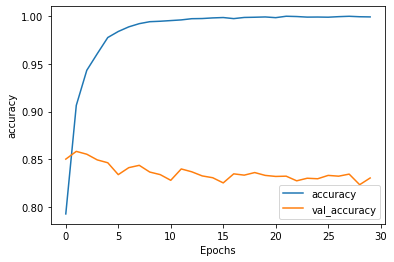

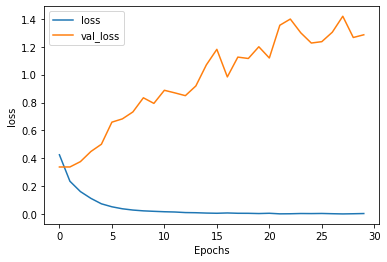

In [13]:
plot_graphs(history_stacked, 'accuracy')
plot_graphs(history_stacked, 'loss')

# Optimize stacked LSTMs with learning-rate and drop-out

### 1. Reduce learning-rate by 20%

In [14]:
reducedLR_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)
reducedLR_model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

reducedLR_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 64)         12544     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 197,773
Trainable params: 197,773
Non-tr

In [15]:
history_reducedLR = reducedLR_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 78s 96ms/step - loss: 0.6918 - accuracy: 0.5583 - val_loss: 0.6899 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 68s 94ms/step - loss: 0.6888 - accuracy: 0.5596 - val_loss: 0.6859 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 68s 95ms/step - loss: 0.6862 - accuracy: 0.5596 - val_loss: 0.6834 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6852 - accuracy: 0.5596 - val_loss: 0.6826 - val_accuracy: 0.5700
Epoch 5/30
719/719 [==============================] - 68s 95ms/step - loss: 0.6846 - accuracy: 0.5596 - val_loss: 0.6819 - val_accuracy: 0.5700
Epoch 6/30
719/719 [==============================] - 68s 95ms/step - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6807 - val_accuracy: 0.5700
Epoch 7/30
719/719 [==============================] - 68s 95ms/step - loss: 0.6824 - accuracy: 0.5596 - val_loss: 0.6790 - val_accuracy:

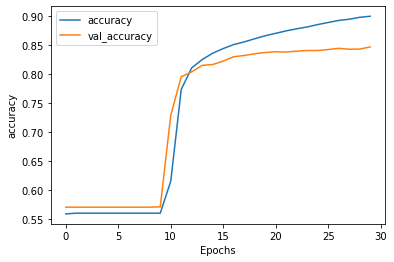

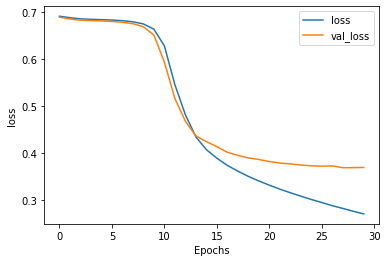

In [16]:
plot_graphs(history_reducedLR, 'accuracy')
plot_graphs(history_reducedLR, 'loss')

learning-rate is a keeper.


### 2. Apply 20% drop-out 

Note: this will slow down the training

In [17]:
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, dropout = 0.2)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         12544     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 197,773
Trainable params: 197,773
Non-tr

In [18]:
history_dropout = dropout_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 86s 108ms/step - loss: 0.4098 - accuracy: 0.7991 - val_loss: 0.3302 - val_accuracy: 0.8595
Epoch 2/30
719/719 [==============================] - 75s 105ms/step - loss: 0.2419 - accuracy: 0.9006 - val_loss: 0.3376 - val_accuracy: 0.8525
Epoch 3/30
719/719 [==============================] - 75s 104ms/step - loss: 0.1837 - accuracy: 0.9288 - val_loss: 0.3592 - val_accuracy: 0.8528
Epoch 4/30
719/719 [==============================] - 74s 103ms/step - loss: 0.1413 - accuracy: 0.9487 - val_loss: 0.3892 - val_accuracy: 0.8482
Epoch 5/30
719/719 [==============================] - 76s 106ms/step - loss: 0.1075 - accuracy: 0.9626 - val_loss: 0.4817 - val_accuracy: 0.8442
Epoch 6/30
719/719 [==============================] - 75s 104ms/step - loss: 0.0808 - accuracy: 0.9724 - val_loss: 0.5135 - val_accuracy: 0.8501
Epoch 7/30
719/719 [==============================] - 75s 104ms/step - loss: 0.0652 - accuracy: 0.9772 - val_loss: 0.5835 - val_ac

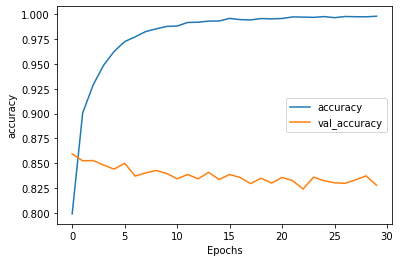

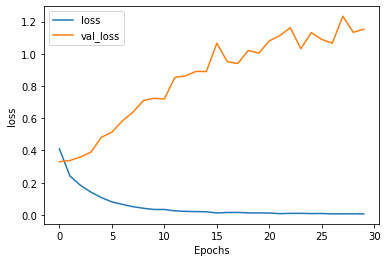

In [19]:
plot_graphs(history_dropout, 'accuracy')
plot_graphs(history_dropout, 'loss')

### Compare 3 results

Accuracy

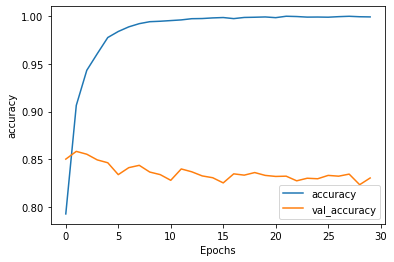

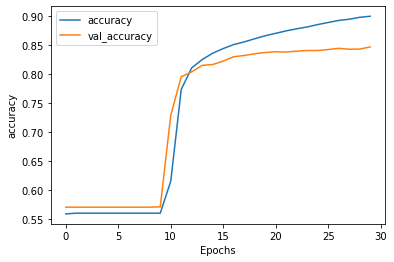

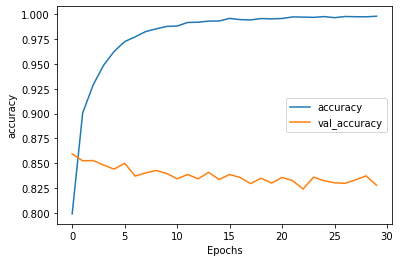

In [20]:
plot_graphs(history_stacked, 'accuracy')
plot_graphs(history_reducedLR, 'accuracy')
plot_graphs(history_dropout, 'accuracy')

Loss

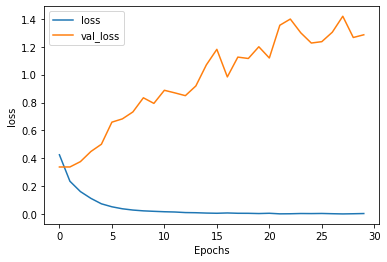

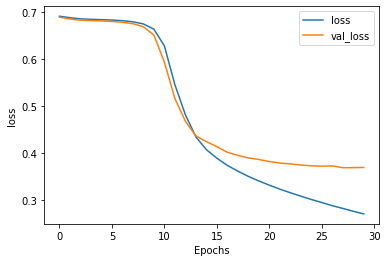

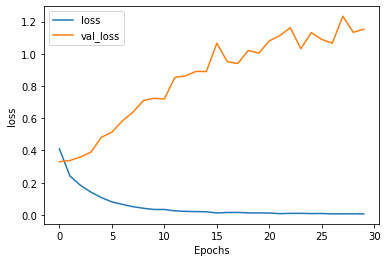

In [21]:
plot_graphs(history_stacked, 'loss')
plot_graphs(history_reducedLR, 'loss')
plot_graphs(history_dropout, 'loss')

## Result

Learning-rate is useful, but drop-out does little 

## Hence, final model: stacked-LSTMs + learning-rate 


# Model 7: apply 27-billion token in 25 dimensions from Twitter trained embeddings 

## Twitter data overview

A 27-billion token, 1.2-million word vocab in 25/50/100/200 dimensions from Twitter crawl of 2 billion Tweets, is part of GloVe (Global Vectors for Word Presentation model, developed by Jeffrey Pennington, Richard Socher, and Christopher Manning at Stanford. 

It is available here https://github.com/stanfordnlp/GloVe


## 1) Select dataset

We will work with the 25-dimension set of Twitter crawl

In [22]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [23]:
print('Loaded %s word vectors.' % len(glove_embeddings))

Loaded 1193515 word vectors.


## 2) Sampling data

In [24]:
print(glove_embeddings['frog'])

# get 3 of dict
N = 3
print("Fist", N, "Dictionary  : ", str(dict(list(glove_embeddings.items())[0: N]))) 

[-1.2158   -0.74924   0.91941   0.72985  -0.12917  -0.19555   1.2365
 -0.77196   0.85161   0.11922   0.16816   0.33334  -2.0845   -0.53471
  0.013538  0.18178   1.2831    0.089331  0.57264   0.50694   0.27134
  0.66504   0.54097  -0.58377   0.67097 ]
Fist 3 Dictionary  :  {'<user>': array([ 0.62415 ,  0.62476 , -0.082335,  0.20101 , -0.13741 , -0.11431 ,
        0.77909 ,  2.6356  , -0.46351 ,  0.57465 , -0.024888, -0.015466,
       -2.9696  , -0.49876 ,  0.095034, -0.94879 , -0.017336, -0.86349 ,
       -1.3348  ,  0.046811,  0.36999 , -0.57663 , -0.48469 ,  0.40078 ,
        0.75345 ], dtype=float32), '.': array([ 0.69586 , -1.1469  , -0.41797 , -0.022311, -0.023801,  0.82358 ,
        1.2228  ,  1.741   , -0.90979 ,  1.3725  ,  0.1153  , -0.63906 ,
       -3.2252  ,  0.61269 ,  0.33544 , -0.57058 , -0.50861 , -0.16575 ,
       -0.98153 , -0.8213  ,  0.24333 , -0.14482 , -0.67877 ,  0.7061  ,
        0.40833 ], dtype=float32), ':': array([ 1.1242  ,  0.054519, -0.037362,  0.10046 ,  

# 3) Exploratory Data Analysis

How many words in our sacarsm dataset, is actually in this Twitter embedding? 

Let's do some counting and then ploting it out

In [25]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

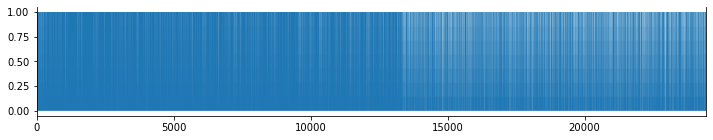

In [26]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
plt.fill(ys)

Notice that density changes somewhere between 10,000 and 15,000.

So let's make vocab-size = 13,000 for below. 

Furthermore, polt the cumulative_x against cumulative_y, 

[0.9170929328477309]


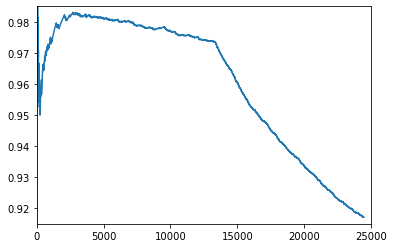

In [27]:
plt.plot(cumulative_x, cumulative_y)
plt.axis([0, 25000, .915, .985])
#plt.axis([13000, 14000, .97, .98])
print(cumulative_y[-1:])

# 4) Update parameters 

In [28]:
vocab_size = 13200 # reflect above EDA analysis result
embedding_dim = 25 # change to 25, to match Twitter file dimension 

embedding_matrix = np.zeros((vocab_size, embedding_dim))
print(embedding_matrix.shape)

(13200, 25)


# 5) Matrix construction 

In [29]:
# max_length = 100  
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print("length of word_index is", len(word_index))
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

length of word_index is 24437


In [30]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [31]:
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
#            print("index is", index, "word is", word, "glove_embeddings.get(word) is", glove_embeddings.get(word))
            embedding_matrix[index] = embedding_vector

## 6) Apply stacked-LSTMs with learning-rate

In [32]:
final_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)
final_model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [33]:
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 25)          330000    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 64)         14848     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 24)                1560      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 371,265
Trainable params: 41,265
Non-tra

In [34]:
history_final = final_model.fit(training_padded, training_labels, epochs=num_epochs, 
                                validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
719/719 - 69s - loss: 0.6912 - accuracy: 0.5162 - val_loss: 0.6820 - val_accuracy: 0.5705 - 69s/epoch - 95ms/step
Epoch 2/30
719/719 - 60s - loss: 0.6802 - accuracy: 0.5600 - val_loss: 0.6748 - val_accuracy: 0.5708 - 60s/epoch - 83ms/step
Epoch 3/30
719/719 - 59s - loss: 0.6742 - accuracy: 0.5625 - val_loss: 0.6686 - val_accuracy: 0.5754 - 59s/epoch - 82ms/step
Epoch 4/30
719/719 - 69s - loss: 0.6663 - accuracy: 0.5810 - val_loss: 0.6593 - val_accuracy: 0.5980 - 69s/epoch - 96ms/step
Epoch 5/30
719/719 - 67s - loss: 0.6541 - accuracy: 0.6117 - val_loss: 0.6457 - val_accuracy: 0.6309 - 67s/epoch - 93ms/step
Epoch 6/30
719/719 - 68s - loss: 0.6367 - accuracy: 0.6550 - val_loss: 0.6272 - val_accuracy: 0.6649 - 68s/epoch - 95ms/step
Epoch 7/30
719/719 - 62s - loss: 0.6156 - accuracy: 0.6793 - val_loss: 0.6079 - val_accuracy: 0.6878 - 62s/epoch - 86ms/step
Epoch 8/30
719/719 - 61s - loss: 0.5983 - accuracy: 0.6901 - val_loss: 0.5965 - val_accuracy: 0.6910 - 61s/epoch - 84ms/step


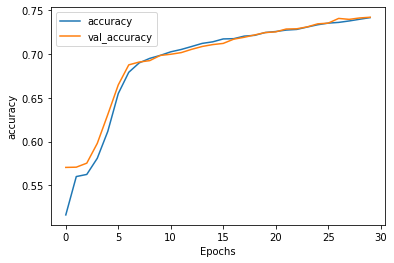

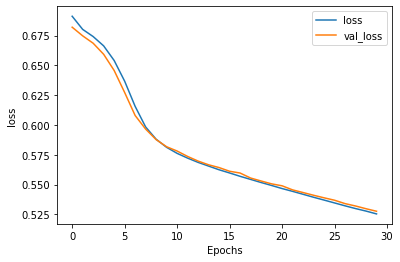

In [35]:
plot_graphs(history_final, "accuracy")
plot_graphs(history_final, "loss")

### Look at that!  

Now we could try to train it for a long time, and then compare for early stopping, etc. But at 30 epochs, we are seeing excellent results.

# Optional: visualize the Embeddings

Embedding Project http://projector.tensorflow.org/ is a very cool visualization tool for word vectoring/embeddings, of course assuming your work is correct (otherwise, it will project words wrongly associated together). 

It uses two tab-separated-values (TSV) files, one for vector-dimensions and one fo meta-data, and we are generating our files, to be uploaded there. 

In [38]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear sons web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear sons web series closest thing she will have to grandchild 
1


In [39]:
e = final_model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(13200, 25)


In [40]:
print(reverse_word_index[2])
print(weights[2])

to
[ 0.28228   0.019558  0.11509  -0.39242  -1.0503   -0.54278   1.1357
 -0.34251   0.80636  -0.47359  -0.77194  -0.73689  -6.2619   -0.34902
 -0.35532  -0.60148  -0.054534 -0.67057  -0.39972  -1.324    -0.43765
  0.30045   0.2143    0.25422  -0.26674 ]


In [41]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Go to http://projector.tensorflow.org/, upload the two files "vectors.tsv" and "metadata.tsv", and see the results! 
    